In [1]:
%load_ext autoreload
%autoreload 2

from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df, create_continuity_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/duration_matrix_BICYCLE.csv')

continuity = create_continuity_df('data/raw/continuity.csv')

In [2]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
test_caregivers = caregivers.loc[test1_subset]
test_tasks = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]
small_test = (test_caregivers, test_tasks)

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car'].head(10)
car_tasks = tasks[tasks['PlannedCaregiverID'].isin(car_caregivers.index)]
car_test = (car_caregivers, car_tasks)

full_test = (caregivers, tasks)

In [5]:
from models.fixed_model import FixedModel
from models.tsp_model import TSPModel
model_type = FixedModel
model_caregivers, model_tasks = car_test

model = model_type(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix, continuity)
model.build(
        # caregiver_penalty=0,
        # overtime_penalty=0,
        # worktime_per_break=0,
        # continuity_penalty=0,
)
model.optimize(
    # NoRelHeurWork=120, 
    # Heuristics=0.2, 
    # MIPFocus=1
)

Created base variables.
Built base model.
Adding overtime penalties.
Adding caregiver usage penalties.
Adding break requirements.
Adding continuity of care penalties.
Updated objective function with penalties.
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 82951 rows, 163930 columns and 524790 nonzeros
Model fingerprint: 0x35043ad7
Variable types: 80130 continuous, 83800 integer (83800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 80234 rows and 86154 columns
Presolve time: 0.04s
Presolved: 2717 rows, 77776 columns, 338343 nonzeros
Variable types: 30 continuous, 77746 integer (77746 binary)
Found heuristic solution: objective 69841.500000
Performing another presolve...
Presolve removed 30 rows a

<gurobi.Model MIP instance HomeCare: 82951 constrs, 163930 vars, Parameter changes: Username=(user-defined), LicenseID=2634432>

<string>:266: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


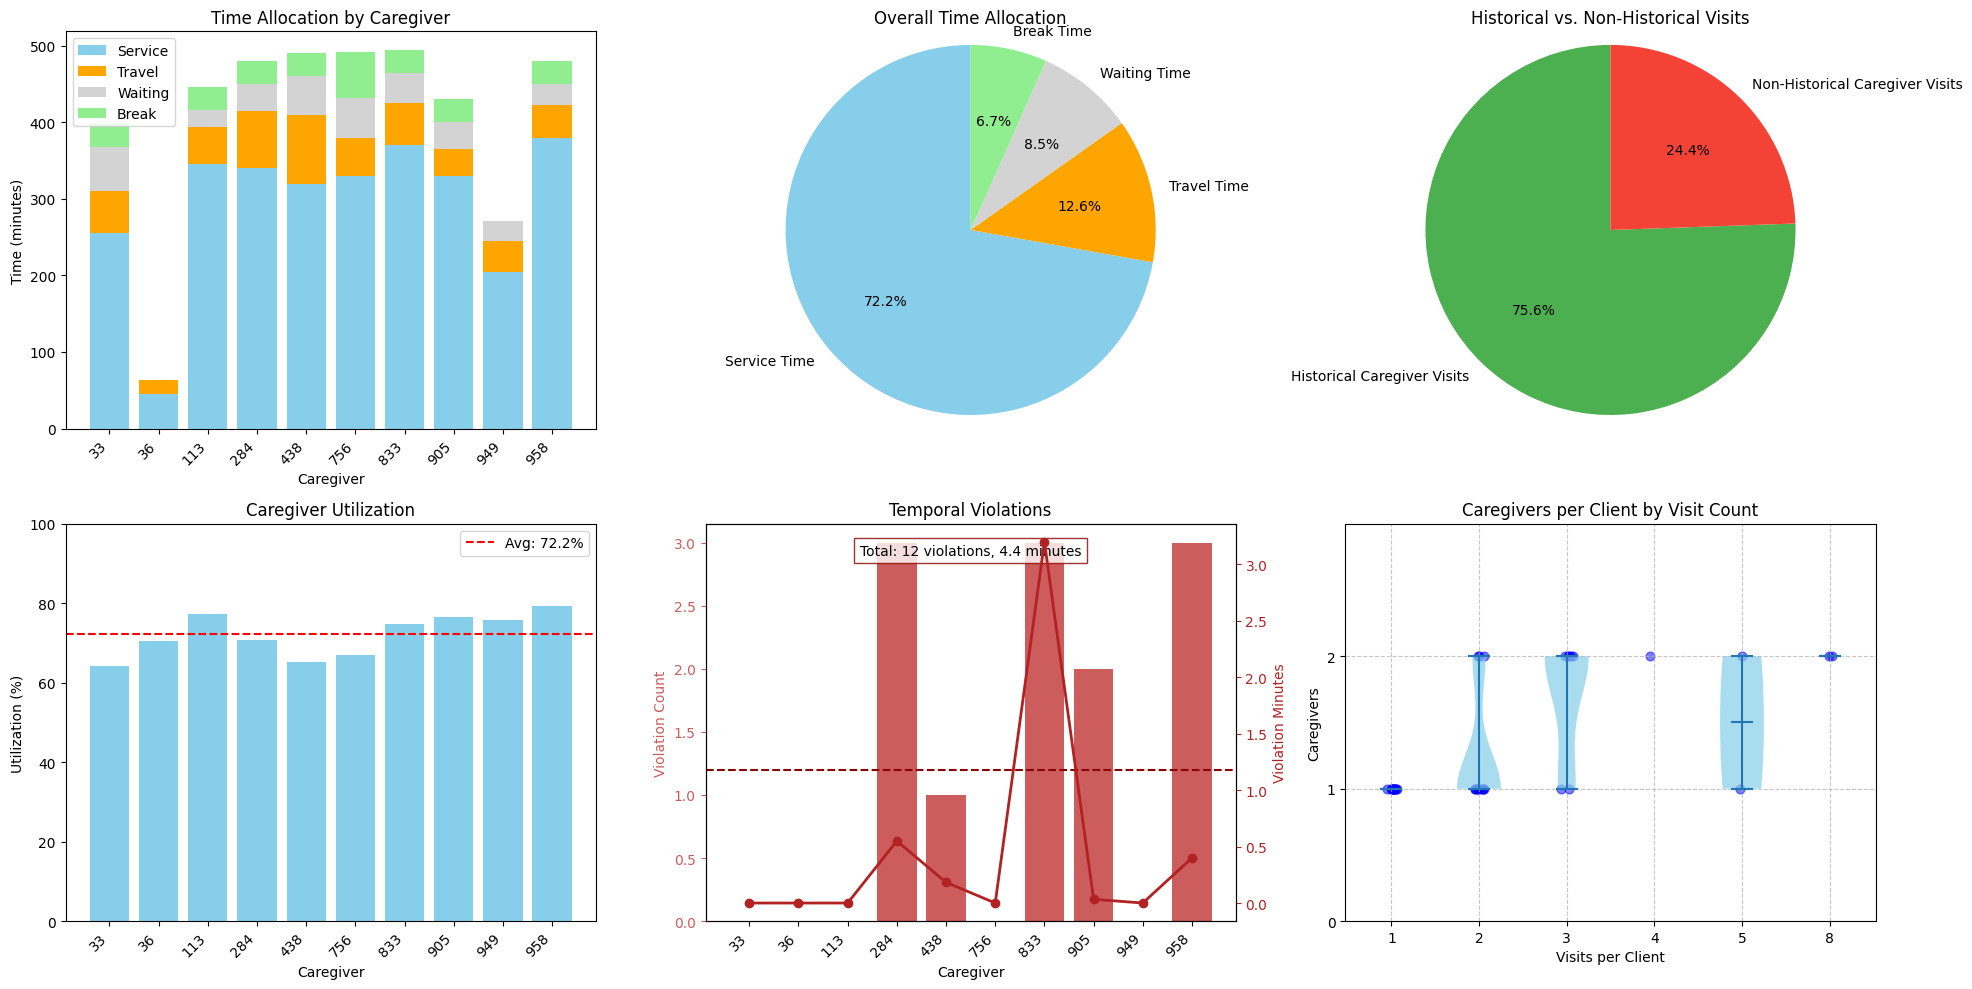

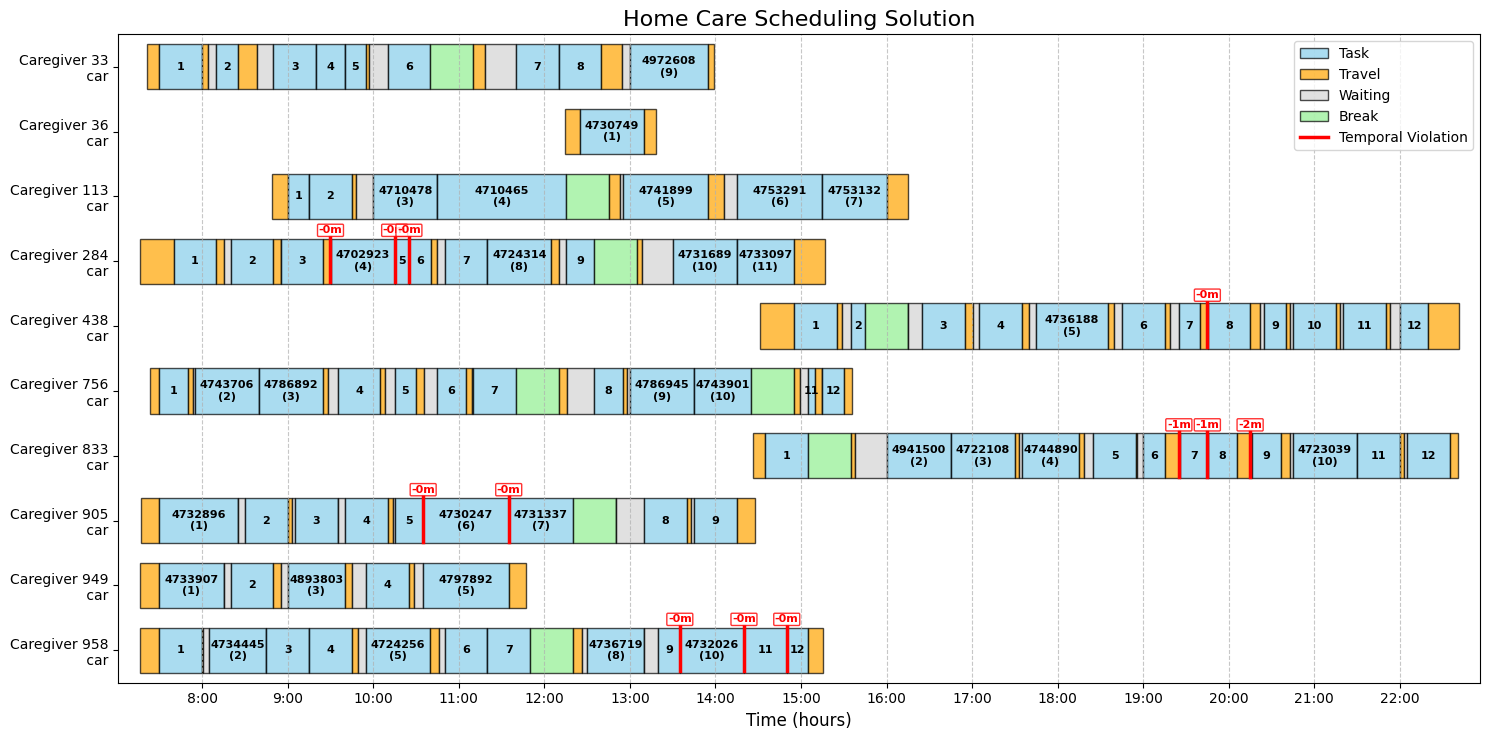

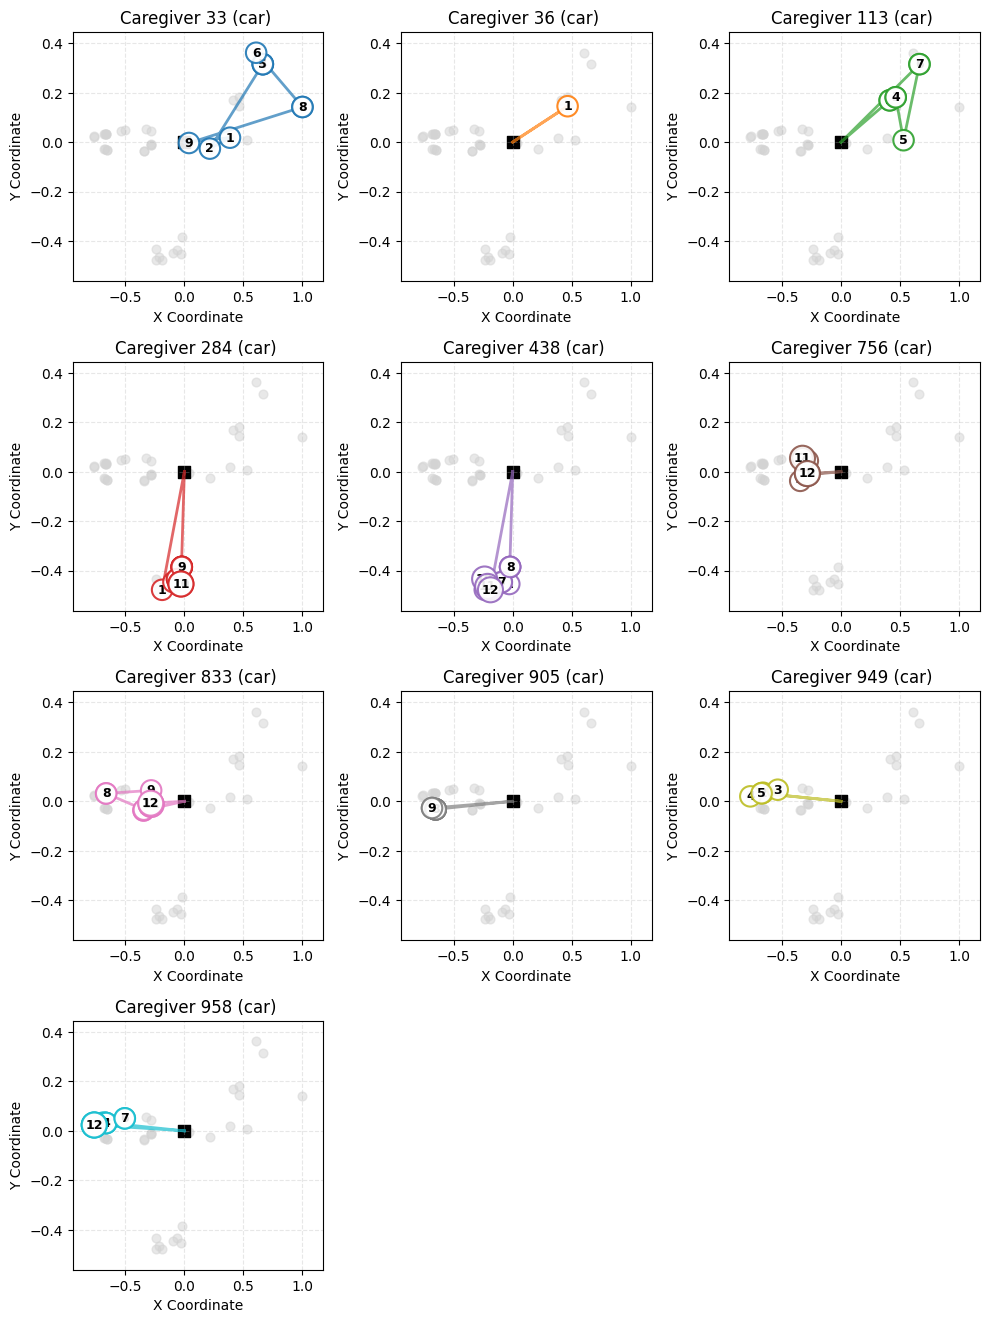

In [20]:
from utils.visualization import visualize_schedule, visualize_metrics, visualize_routes, display_metrics_summary

model.get_solution()

#display_metrics_summary(model)
visualize_metrics(model, display_mode='dashboard');
visualize_schedule(model);
visualize_routes(model, caregiver_ids=None, subplot_mode=True);

In [35]:
from utils.solution_storage import save_solution
save_solution(model, 'full_test_first_draft')

Solution saved to data/saved_solutions/20250331_081731_full_test_first_draft.json


'data/saved_solutions/20250331_081731_full_test_first_draft.json'

In [17]:
from utils.solution_storage import create_model_from_real_data

real_data_model = create_model_from_real_data(model.caregivers, model.tasks, model.clients, model.drive_time_matrix, model.walk_time_matrix, model.bicycle_time_matrix, model.continuity)

display_metrics_summary(real_data_model)
visualize_metrics(real_data_model, display_mode='dashboard')
visualize_schedule(real_data_model)
visualize_routes(real_data_model, caregiver_ids=None, subplot_mode=True)



                              HOME CARE SCHEDULE METRICS SUMMARY

SCHEDULE OVERVIEW:
  Total tasks:              90
  Active caregivers:        9/10

TEMPORAL VIOLATIONS:
  Total violations:         14
  Total violation minutes:  14.8 min
  Caregivers with violations: 5/9
  Avg violations per caregiver: 1.6

TIME ALLOCATION:
  Service time:             2920 min (74.8%)
  Travel time:              490 min (12.5%)
  Waiting time:             493 min (12.6%)
  Break time:               0 min (0.0%)
  Total schedule time:      3903 min

CONTINUITY METRICS:
  Historical visits:        63/90 (70.0%)
  Avg caregivers per client: 1.3
  Historical continuity:    72.9%
  Perfect continuity:       28 clients
  Perfect historical:       25 clients

AVERAGE PER CAREGIVER:
  Tasks:                    10.0
  Service time:             324 min
  Travel time:              54 min
  Waiting time:             55 min
  Break time:               0 min
  Utilization:              74.8%

TOP 5 LARGEST TEMPORA

KeyError: 2

In [58]:
# Display all tasks with PlannedCaregiverID 33, sorted by start_minutes
model.tasks[model.tasks['PlannedCaregiverID'] == 438].sort_values('start_minutes')


,ClientID,StartTime,EndTime,TaskType,PlannedCaregiverID,start_minutes,end_minutes,duration_minutes
ID,,,,,,,,
4940776,1453,2025-03-05T07:30:00+01:00,2025-03-05T07:50:00+01:00,Dubbelbemanning,438,450,470,20
4743706,396,2025-03-05T07:55:00+01:00,2025-03-05T08:40:00+01:00,Hemtjänst,438,475,520,45
4786892,396,2025-03-05T08:40:00+01:00,2025-03-05T09:25:00+01:00,Hemtjänst,438,520,565,45
4734848,1419,2025-03-05T09:35:00+01:00,2025-03-05T10:05:00+01:00,Hemtjänst,438,575,605,30
4885322,396,2025-03-05T10:15:00+01:00,2025-03-05T10:30:00+01:00,Hemtjänst,438,615,630,15
4887383,1464,2025-03-05T10:45:00+01:00,2025-03-05T11:05:00+01:00,Hemtjänst,438,645,665,20
4735978,1467,2025-03-05T11:10:00+01:00,2025-03-05T11:40:00+01:00,Hemtjänst,438,670,700,30
4941319,1453,2025-03-05T12:35:00+01:00,2025-03-05T12:55:00+01:00,Dubbelbemanning,438,755,775,20
4786945,396,2025-03-05T13:00:00+01:00,2025-03-05T13:45:00+01:00,Hemtjänst,438,780,825,45
